<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/multi-discriminator%20GAN%200901.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Discriminator GAN


ABSTRACT

----


#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install keybert
!pip3 install transformers
!pip3 install sentence-transformers

#!pip install sentence-transformers

     |████████████████████████████████| 2.8 MB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 55.2 MB/s 
     |████████████████████████████████| 50 kB 9.0 MB/s 
     |████████████████████████████████| 636 kB 60.1 MB/s 
     |████████████████████████████████| 895 kB 63.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 67.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=a1f406670ec4f160dd2616e825877ec68779458c55ce390ad7b2216b49fd28e6
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers


In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
#seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                print()
        self.back_filledLength = filledLength    

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

##4.2 Grammar Discriminator Class

In [7]:
from transformers import BertTokenizer, BertTokenizerFast,AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 10:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pretraoned_kobert_model_name='kykim/bert-kor-base', input_dir=None):

        if input_dir is None:
            self.tokenizer = BertTokenizerFast.from_pretrained(pretraoned_kobert_model_name)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pretraoned_kobert_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)




    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                outputs = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                loss, logits = outputs.loss, outputs.logits
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    outputs = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                loss, logits = outputs.loss, outputs.logits
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizerFast.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        outputs = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)

        #print(outputs)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return outputs['loss'], outputs['logits']


# 문법 discriminator의 학습

In [7]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/summary/korean_news_corpus.csv')
df

,title,contents
0,문 대통령 변창흠 국토장관 사의표명 사실상 수용,정만호 국민소통수석이 12일 오후 청와대 춘추관 대브리핑룸에서 변창흠 국토부 장관 ...
1,계급장 수여하는 문 대통령,(아산뉴스1) 이광호 기자 문재인 대통령이 12일 오후 충남 아산시 경찰대학에서 열...
2,계급장 수여하는 문 대통령,(아산뉴스1) 이광호 기자 문재인 대통령이 12일 오후 충남 아산시 경찰대학에서 열...
3,수상자 메달 걸어주는 문 대통령,(아산뉴스1) 이광호 기자 문재인 대통령이 12일 오후 충남 아산시 경찰대학에서 열...
4,정몽구 서울아산병원에 50억 쾌척,인재 양성·소외 계층 지원 등 계획 “부친 질병·가난 악순환 끊기 원해 국내 최고 ...
...,...,...
140559,[건축과도시] 북한산을 캔버스 삼아. 미술관 또 하나의 작품이 되다,<은평구 진관동 사비나 미술관> 서울시 은평구 진관동에 자리잡은 사비나미술관. 삼각...
140560,조선후기 문인 김조순 별장 그린 옥호정도 첫 공개,국립중앙박물관 서화실 개편해 32점 새롭게 전시 옥호정도[국립중앙박물관 제공연합뉴스...
140561,안성 청룡사 대웅전에서 목재 곡자 발견,문화재청(청장 정재숙)의 국고보조와 기술지도로 안성시에서 시행하고 있는 안성 청룡사...
140562,156년전 ㄱ자 곡자 찾았다 안성 청룡사 기둥 밑에서,안성 청룡사 대웅전에서 발견된 곡자 【서울뉴시스】 이수지 기자 안성 청룡사 대웅전에...


In [8]:
import re
import sys

import nltk
nltk.download('punkt')

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    txt = txt.replace('”','')
    txt = txt.replace('“','')
    txt = txt.replace('’','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    #txt = txt.replace('.','. ')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()
    
# 검사...
pattens = ["[34569][0-9]{3}[\;.\;-\; ][0-9]{4}[\;.\;-\; ][0-9]{4}[\;.\;-\; ][0-9]{4}",
           "[0-9]{2,3}[\:\s\;.\;,\;-;)][0-9]{3,4}[\:\s\;.\;,\;-][0-9]{4}",
           "[0-9]{1}[0-9]{1}[\W]?[0-1]{1}[0-9]{1}[\W]?[0-3]{1}[\W]?[0-9]{1}[\W]?[1-4]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}",
           "[0-9]{2}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{3}[\:\s\;.\;,\;-]([0-9]{5,6}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{6}[\:\s\;.\;,\;-][0-9]{5}|[0-9]{2,3}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{7}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{4,6}[\:\s\;.\;,\;-][0-9]|[0-9]{5}[\:\s\;.\;,\;-][0-9]{3}[\:\s\;.\;,\;-][0-9]{2}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{5}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{4}[\:\s\;.\;,\;-][0-9]{4}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{6}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{7})|[0-9]{4}[\:\s\;.\;,\;-]([0-9]{3}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{6}[\:\s\;.\;,\;-][0-9])|[0-9]{5}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{6}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{5,6}"
           ]

filters = []
for p in pattens:
    filters.append(re.compile(p))

sentences = []
df = df.dropna(axis=0)
cnt = df['contents'].count()
#print('Total row count:',cnt)
i=0
for raw_text in df['contents']:
    i=i+1
    try:
        if i%100 == 0:
            percent = ("{0:.2f}").format(100 * (i / float(cnt)))
            print(f'\r {percent}% {i}/{str(cnt)}', end="", flush=True)

        docs = nltk.sent_tokenize(clean_text(raw_text))
        for txt in docs:
            if txt.find('▶') > -1 or txt.find('@') > -1 or txt.find('ⓒ') > -1: 
                pass
            else:
                txt = txt.strip()
                if any(chr.isdigit() for chr in txt) :
                    pass
                else:
                    sentences.append(txt)
    except KeyboardInterrupt as ki:
        raise ki        
    except:
        pass #print("Unexpected error:", sys.exc_info()[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 99.97% 140500/140536

In [9]:
import re
import sys
import io

#텍스트 정제(전처리)
def cleanText(readData):
    #텍스트에 포함되어 있는 특수 문자 제거
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》◆◇●🎧○▲\t―△━▷]', '', readData)
    return text.lower()

In [10]:

c_sentences = []
for sentence in sentences:
    s = cleanText(sentence)
    c = len(s.split())
    if c >= 3 and c < 10 and s.find('재배포') < 0 and s.find('기자') < 0  and s.find('유투브') < 0 and s.find('www') < 0 and s.find('com') < 0 and s.find('접속하기') < 0 and s.find('http') < 0 and s.find('뉴스') < 0 and s.find('일보') < 0 :
        if s.endswith(('다','요')):
            c_sentences.append(s.strip())

In [11]:
len(c_sentences)

868830

In [12]:
import json  
import zipfile  

data_1 = None  
data = None  
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/summary/data/사설잡지_2.train_original.json.zip", "r") as z:
    with z.open('train_original.json') as f:  
        data = f.read()  
        data_1 = json.loads(data.decode("utf-8"))

In [13]:
data_2 = None  
data = None  
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/summary/data/신문기사_2.train_original.json.zip", "r") as z:
    with z.open('train_original.json') as f:  
        data = f.read()  
        data_2 = json.loads(data.decode("utf-8"))

In [14]:

for i in range(len(data_2)):
    for txt in data_2[i]['article_original']:
        c_sentences.append(txt)
for i in range(len(data_1)):
    for txt in data_1[i]['article_original']:
        c_sentences.append(txt)    

In [15]:
len(c_sentences)

5275990

In [16]:
random.shuffle(c_sentences)

In [17]:
ko_sentences_dataset = c_sentences

use_pretrained_model = False

if use_pretrained_model:
    #g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/model_save')
    g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model4')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(ko_sentences_dataset[:1000000])
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences,labels)
    g_discriminator.train(epochs=1)
    g_discriminator.save_model(output_dir='/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model4')

1049658


Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

 Original:  소주업계가 수년간 가격을 담합한 것으로 드러나 200억원 이상 과징금을 물게 된 것도 눈여겨볼 만하다
Original:  소주업계가 수년간 가격을 담합한 것으로 드러나 200억원 이상 과징금을 물게 된 것도 눈여겨볼 만하다
Token IDs: tensor([    2, 22301, 24357,  8048, 39166,  8154, 20993,  3125,  8261,  8112,
        14212, 30163, 14197, 16044, 14144,  2287,  8336, 15534,  4223,  8111,
         3292, 14404, 27061,  8377, 35751,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
944,692 training samples
104,966 validation samples
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (42000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embe

# 문법 discriminator 활용

In [8]:
g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model4')

Loading BERT tokenizer...


In [9]:
txt = ['최근 날씨가 포근해지면서 산을 찾는 사람들도 늘고 있는데요','서비스를 음원 플랫폼 스포티파이가 국내  론칭한다']
g_discriminator.discriminator.to(device)
g_discriminator.transfer_learning(txt)

(tensor(5.5182, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[-5.3232,  4.9450],
         [ 5.5429, -5.4935]], device='cuda:0', grad_fn=<AddmmBackward>))

##4.3 Static similarity discriminator class

In [10]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='xlm-r-large-en-ko-nli-ststb'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 한국어 문장 유사도 pre-trained model 적용

In [11]:
s_discriminator = Similarity_Discriminator()
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


Downloading:   0%|          | 0.00/795 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

# 4.4 Document source class

## 두 문장을 합치는 rule 변환기... --> 이거... ML로 나중에 바꿔야...

In [12]:
combine_matching_table = {}

combine_matching_table['어요.'] = '고'
combine_matching_table['지요.'] = '고'
combine_matching_table['답니다.'] = '고'
combine_matching_table['보거라.'] = '봐,'
combine_matching_table['간단다.'] = '가니,'
combine_matching_table['돼.'] = '되,'
combine_matching_table['해.'] = '하며,'
combine_matching_table['다.'] = '고'


In [13]:
def combine_sentence(txt):
    for c in combine_matching_table.keys():
        if txt.endswith(c):
            txt = txt.replace(c,combine_matching_table[c])
    return txt

In [14]:

conjunction_table = ['그러던','그래서','그러나','그런데','그리고','그랬더니','그러니까','하지만','그래서']

## 4.4.2 source class 구현

In [55]:


class Source:

    def __init__(self,full_text,org_text):
        self.full_text = full_text
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

    def set_key_rate(self,s_discriminator):
        self.full_text = self.__crean_text(self.full_text.strip())
        self.org_text = self.__crean_text(self.org_text.strip())
        print('-'*50)
        print(self.org_text)
        print('-'*50)
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        for i,sents in enumerate(self.org_sentences):
            for cj in conjunction_table: 
                if sents.startswith(cj):
                    self.org_sentences[i] = sents[len(cj):].strip()

        self.full_sentences = np.array(nltk.sent_tokenize(self.full_text))
        
        #self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_term_set = (' '.join(self.org_sentences)).strip().split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        self.seps = []
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
            if word.endswith(('.','?')):
                self.seps.append(index)
                if self.org_source_length - 1 == index:
                    pass
                else:
                    self.term_table[index] = combine_sentence(word)

        #print(self.term_table.values())
        #print('------------------------------------------------------------------')

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        self.full_text_emb = self.s_discriminator.encode(self.full_sentences)
        #top_n = int(len(self.term_table) * comp_rate)
        #print('top_n',top_n)
        #self.story_peaks = [i+1 for i in range(top_n)]

    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

    def get_random_text(self,rate=0.7):
        cnt = int(len(self.term_table) * rate)
        a = list(self.term_table.keys())
        b = np.random.choice(a, cnt)
        c = [fruit for fruit in a if fruit not in b]
        txt = []
        for i in c:
            txt.append(self.term_table[i])
        return ' '.join(txt).strip(), hash(tuple(b))

In [23]:
txt = """
황금마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼어요. 
그러니까 반드시 밤 열두시가 되기 전에 돌아와야 해요.
"""
s = Source(txt)
s.set_key_rate(s_discriminator)
s.get_random_text()

--------------------------------------------------
황금마차는 호박으로 흰말은 생쥐로 마부는 도마뱀으로 변하게 돼어요. 그러니까 반드시 밤 열두시가 되기 전에 돌아와야 해요.
--------------------------------------------------


('황금마차는 호박으로 변하게 돼고 밤 전에 돌아와야', 3178842640334032236)

# 4.5 Generator class

In [91]:
from functools import reduce


# custom weights initialization called on netG and netD
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.06)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.0, 0.05)
        m.bias.data.fill_(0)
'''
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    '''
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size*3),
            nn.BatchNorm1d(input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*3),
            nn.BatchNorm1d(input_size*3),
            nn.LeakyReLU(0.2),            
            nn.Linear(input_size*3, input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        l1 = nn.Linear(input_size, input_size*4)
        l1.weight.data.normal_(0.0, 0.03)
        bn = nn.BatchNorm1d(input_size*4)
        bn.weight.data.normal_(0.0, 0.05)
        bn.bias.data.fill_(0)        
        l2 = nn.Linear(input_size*4, input_size)
        l2.weight.data.normal_(0.02, 0.05)
        self.layer = nn.Sequential(
            l1,
            bn,
            nn.LeakyReLU(0.2),
            l2,
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )

    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_


# multi-discriminator에 대한 Adaptive discriminant factor 를 구하기 위한 학습

## 이론

ref : https://realpython.com/python-ai-neural-network/

colab 수식입력 : 

https://wikidocs.net/1679

https://en.wikipedia.org/wiki/Help:Displaying_a_formula#Formatting_using_TeX

Original GAN의 목적함수
$$ \min_{G}\max_{D} V(D,G) = E_{x\sim p_{data}(x)}[logD(x)] + E_{z\sim p_{z}(z)}[log(1-D(G(z)))] $$

Multi-Discriminator GAN은 discriminator가 각 목적에 의하여 여러개 (N개) 있다.
MDGAN의 목적함수

$$ \min_{G}\max_{D_{i\sim N}} V(D_{i\sim N},G) = \sum_{i=1}^N \{E_{x\sim p_{data}(x)}[logD_i(x)] + E_{z\sim p_{z}(z)}[log(1-D_i(G(z)))]\} $$

여기서

$$ L(D_i,G) =  E_{x\sim p_{data}(x)}[logD_i(x)] + E_{z\sim p_{z}(z)}[log(1-D_i(G(z)))] $$

이라하고 단순화 하면

$$ \min_{G}\max_{D_{i\sim N}} V(D_{i\sim N},G) = \sum_{i=1}^N L(D_i,G) $$

와 같이 된다.

문제점은 GAN의 특성상, 특정 Discriminator가 학습에 있어 지배적으로 loss 함수에 영향을 미치게 되어 각각의 Discriminator가 골고루 학습에 참여하지 못하고 의도하지 않은 결과를 만들게 된다. 이러한 문제점을 극복하기 위해 다음의 두가지 제안을 한다.

1) 목적함수에 각 Loss 에 대한 표준편차 (standard-deviation) 를 반영하여 각 Discriminator에 대한 Loss가 상호 유사한 수준을 유지하면 학습이 진행되도록 한다.

$$ \min_{G}\max_{D_{i\sim N}} V(D_{i\sim N},G) = \sum_{i=1}^N L(D_i,G) + STD_{i \sim N}(L(D_i,G))$$

2) 1)의 제안에 추가하여, 각 discriminator에 의한 loss를 제어하기 위해, adaptive discriminant factor (ADF) 를 적용하고, 학습의 진행 과정에서 이를 최적화 한다. 

$$ \min_{G}\max_{D_{i\sim N}} V(D_{i\sim N},G) = \sum_{i=1}^N f_iL(D_i,G) + STD_{i \sim N}(L(D_i,G))$$

여서서 

fi = adaptive discriminant factor for discriminator i 

중요한 것은, 학습과정에서 Li을 작게 (학습의 방향)하기 위해서는 fi는 역으로 커져야 한다. 그래야, 전체 Loss function에서 비중이 증대되어 더 적극적인 학습이 이루어 지게 된다. 따라서, fi의 최적화 방향은 기존의 gradient decent와 반대 방향이 되어야 한다.

$$ f_i^{t+1} = f_i^t + \alpha \frac{\partial V}{\partial f_i}$$

##4.6 Summarizer class (GAN training)

# 학습기...

In [83]:
import random
import math
import numpy as np
from scipy.special import expit
from transformers import get_linear_schedule_with_warmup

class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        #self.c_discriminator = c_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)
        #self.generator.apply(weights_init)
        return self

    def summarize(self,epochs=10,batch_size=1,learning_rate=2e-4, display = False):
        history = self.__train(epochs,batch_size,learning_rate,display)
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='grammar loss')
            plt.plot(history['gen_l_loss'],label='compression loss')
            plt.plot(history['gen_s_loss'],label='similarity loss')

            plt.plot(history['total loss'],label='total loss')
            plt.plot(history['losses std'],label='standard deviation of losses')
            
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return history

    # text의 생성 for torch
    def __text_gen2(self, p_txt, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(p_txt, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        #print(gen_length)
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __text_gen3(self, p_txt):
        gtext = []

        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext.append(self.source.term_table[order])
        return gtext

    def __text_gen4(self, p_txt):
        gtext = ""
        indexs = []
        for order,p in enumerate(p_txt):
            if p > 0.0:
                gtext += self.source.term_table[order] + ' '
                indexs.append(order)
        return gtext.strip(),indexs


    def __discrete_gradient(self,weights,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        #fake_com_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)
        fake_len_out = torch.zeros(weights.shape).to(device) 

        #real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        #real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            #gtext = self.__text_gen2(noise,gen_length)
            gtext,tk = self.__text_gen4(noise)
            fake_outs.append(gtext)
            apply_order.append((i,tk))
  
        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)

        o_sim_out = []
        o_len_out = []
        for fake_text in fake_outs:
            s1 = self.s_discriminator.similarity(fake_text,self.source.org_text_emb)
            s2 = self.s_discriminator.similarity(fake_text,self.source.full_text_emb)
            s = ((s1+s2)/2 - 0.5) * 2
            #print(s1,s2,s)
            o_sim_out.append(s)

            l = ((1 - len(fake_text.split(' '))/self.source.org_source_length)-0.5) * 2

            o_len_out.append(l)
            #print(1 - len(fake_text.split(' '))/self.source.org_source_length)
            #o_len_out.append(-len(fake_text.split(' '))/self.source.org_source_length)
        
        
        for j, (i,tk) in enumerate(apply_order):

            try:
                '''
                a = torch.tanh( fake_gmr_out[j,1])
                if a > 0 :
                    fake_gen_out[:] = -0.5
                    fake_gen_out[i,tk] = a
                else:
                    fake_gen_out[:] = 0.5
                    fake_gen_out[i,tk] = a
                '''
                fake_gen_out[i,tk] = torch.tanh( fake_gmr_out[j,1])
                fake_sim_out[i,tk] = o_sim_out[j]
                fake_len_out[:] = o_len_out[j]
                fake_len_out[i,tk] = 0 #torch.tensor(fake_text_len/self.source.org_source_length).to(device)
                #fake_len_out[:] = o_len_out[j] #torch.tensor(fake_text_len/self.source.org_source_length).to(device)
                #print(o_len_out[j])
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_sim_out, fake_len_out #fake_com_out, fake_sim_out #, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,learning_rate=2e-4,display = False):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = int(random.random()*100)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = AdamW(self.generator.parameters(),
                        lr = 2e-3, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )
        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(G_opt, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = epochs)
        
        #gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_len_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    
        total_loss_history = []
        losses_std_history = []

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...
        #self.c_discriminator.discriminator.to(device)
        #self.c_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        #self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        #G_c_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)


        epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
        max_epsilon = 1 # You can't explore more than 100% of the time
        min_epsilon = 0.001 # At a minimum, we'll always explore 1% of the time
        decay = 0.05
        

        dfs = torch.tensor([ 1.0, 1.0, 1.0], device=device, dtype=torch.float, requires_grad=True)

        for i in range(epochs):
   
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device) 

                random_number = np.random.rand()
                # 2. Explore using the Epsilon Greedy Exploration Strategy
                '''
                if random_number <= epsilon:
                    # Explore
                    bias = torch.randn(batch_size,self.source.org_source_length).to(device) / 4 * epsilon
                else:
                '''
                bias = torch.zeros_like(noise).to(device)
                #if i < epochs/4:
                #bias = torch.randn(batch_size,self.source.org_source_length).to(device) / 4                 
                #bias = torch.randn(batch_size,self.source.org_source_length).to(device) 

                sw, sw0 = self.generator(noise,bias)
                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, fake_len_out = self.__discrete_gradient(sw)

                #print(fake_len_out)

                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1) 
                sw2 = sw * fake_gmr_out
                G_g_loss = -torch.mean(sw2) 
                sw3 = sw * fake_len_out
                G_l_loss = -torch.mean(sw3) * 10

                dsc_loss = torch.stack([G_g_loss,G_s_loss,G_l_loss])

                G_loss = torch.dot(dfs,dsc_loss) + torch.std(dsc_loss)
                #G_loss = G_g_loss + G_s_loss

                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                scheduler.step()
                '''
                learning_rate = 0.1
                with torch.no_grad():
                    dfs += learning_rate * dfs.grad
                    dfs.grad = None                    
                    dfs[dfs < 0] = 0.1                
                '''

            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            #gen_com_loss_history.append(G_c_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())
            gen_len_loss_history.append(G_l_loss.cpu().detach().numpy())

            #pb.printProgress(+1,f'{i+1}/{epochs} epochs, beta:{dfs} Generator / grammar loss:{G_g_loss}  similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            #pb.printProgress(+1,'{}/{} epochs, beta:{}, grammar loss:{:.4f}  similarity loss:{:.4f} length loss:{:.4f}'.format(i+1,epochs,dfs,G_g_loss,G_s_loss,G_l_loss)) #,   Discriminator grammar_loss:{D_loss}        ')
            pb.printProgress(+1,'{}/{} epochs, e {}, grammar loss:{:.4f}  similarity loss:{:.4f} length loss:{:.4f}'.format(i+1,epochs,epsilon, G_g_loss,G_s_loss,G_l_loss)) #,   Discriminator grammar_loss:{D_loss}        ')
            
            total_loss_history.append(torch.sum(dsc_loss).item())
            losses_std_history.append(torch.std(dsc_loss).item())

            epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * i)
            
        self.generator.eval()
        #self.g_discriminator.discriminator.eval()
        if display:
            plt.figure(figsize=(12, 6))
            xs = np.arange(self.source.org_source_length)
            plt.bar(xs+0.0,sw0[0].cpu().detach().numpy(),label='before activation weights',width=0.2)
            plt.bar(xs+0.2,sw[0].cpu().detach().numpy(),label='after activation weights',width=0.2)
            plt.bar(xs+0.4,bias[0].cpu().detach().numpy(),label='bias weights',width=0.2)         
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history,'gen_l_loss':gen_len_loss_history,'total loss':total_loss_history,'losses std':losses_std_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        #texts = []
        self.generator.cpu()
        self.generator.eval()
        #gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)

        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        max_score = 0
        max_sim = 0
        comp_rate = 0
        best_text = ""

        for p_txt in sw:
            gtext = self.__text_gen3(p_txt)
            text = ' '.join(gtext)
            #print('>>',text)
            sim_score = self.s_discriminator.similarity(text,self.source.org_text_emb)
            if sim_score > max_sim:
                best_text = text.strip()
                loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
                max_score = out[0,1].item()
                comp_rate = 1 - len(best_text.split(' '))/self.source.org_source_length
                max_sim = sim_score
            #texts.append([text.strip(),out,sim_score])
        return best_text, max_score, max_sim, comp_rate

    def get_samples(self,count):
        self.generator.cpu()
        self.generator.eval()
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
        #samples = []
        best_text = ""
        max_score = 0
        for p_txt in sw:
            gtext = self.__text_gen3(p_txt)
            text = ' '.join(gtext).strip()
            #print(text)
            loss, out=self.g_discriminator.transfer_learning([text],train_for = False)
            sim_score = self.s_discriminator.similarity(text,self.source.org_text_emb)    
            comp_rate = 1 - len(text.split(' '))/self.source.org_source_length
            #samples.append((text,out[0,1].item(),sim_score,comp_rate))
            score = out[0,1].item() + sim_score + comp_rate
            if max_score < score:
                max_score = score
                best_text = text
        #return [best_text for i in range(count)], max_score
        return best_text, max_score


#5. Experiment

## 비교 대상 요약 알고리즘 준비

In [95]:
def sam_wgan4(full_text,text, epochs=50, batch_size=100,display=False, retry = True, retry_count = 0):
    if retry_count > 10:
        raise Exception("Can't summarize the text")

    source = Source(full_text,text)
    source.set_key_rate(s_discriminator)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    hist = summarizer.summarize(epochs,batch_size=2,learning_rate=5e-3,display=display)
    samples, max_score = summarizer.get_samples(batch_size)
    #print(samples)
    if retry and max_score < (4.1 - retry_count*0.1):
        print('max score:',max_score,samples)
        return sam_wgan4(full_text,text, epochs+10, batch_size,display=display,retry_count=retry_count+1)
    return samples, max_score

--------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요.
--------------------------------------------------
Train... |||||||||||||||||||||| 100.0%   50/50 epochs, e 0.09162723533612306, grammar loss:-0.0571  similarity loss:-0.0435 length loss:-0.0026


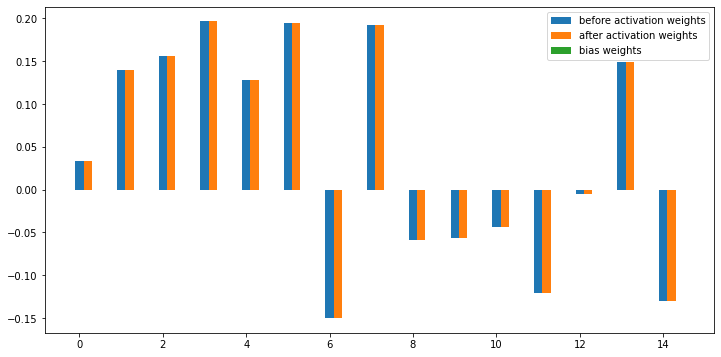

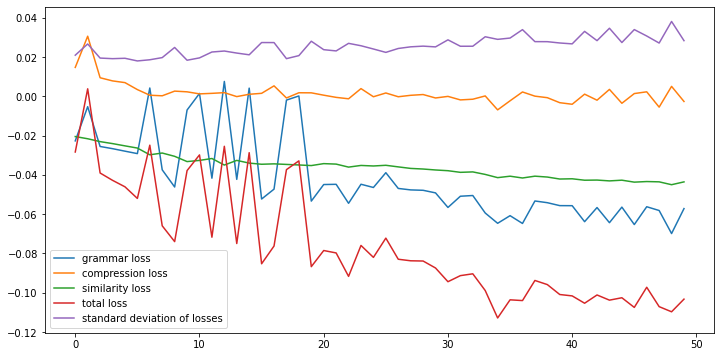

max score: 3.3764197661131674 옛날 어느 집에 귀여운 여자 아기가 아기는 고운 소녀가
--------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요.
--------------------------------------------------
Train... |||||||||||||||||||||| 100.0%   60/60 epochs, e 0.055968196836350806, grammar loss:-0.0293  similarity loss:-0.0195 length loss:-0.0259


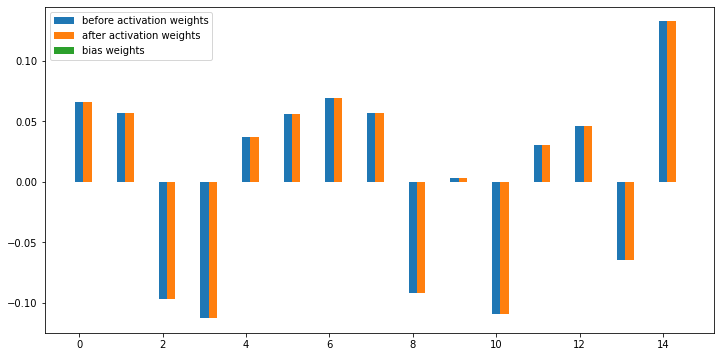

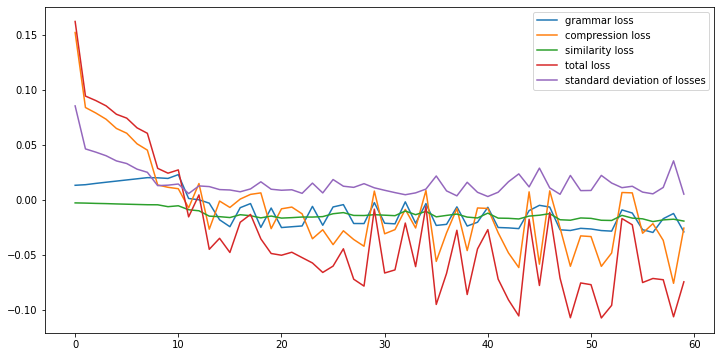

max score: 2.6998723656238695 옛날 어느 여자 아기가 태어났고 아기는 자라서 마음씨 고운 되었어요.
--------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요.
--------------------------------------------------
Train... |||||||||||||||||||||| 100.0%   70/70 epochs, e 0.03433989669036574, grammar loss:-0.0155  similarity loss:-0.0104 length loss:-0.0127


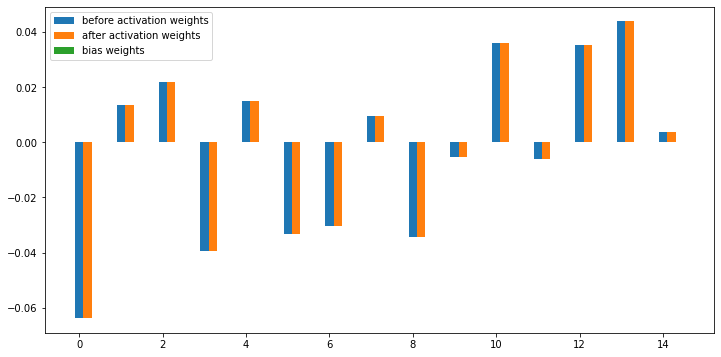

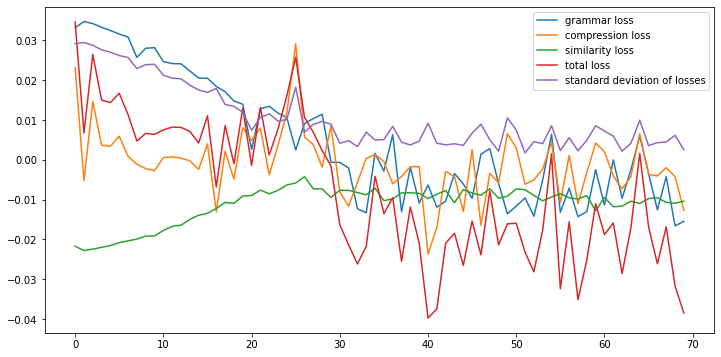

('어느 집에 여자 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요.', 6.138181425228205)

In [85]:
txt = """
옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
"""
sam_wgan4(txt,txt,epochs=50,display= True,retry = True)

--------------------------------------------------
서산시의회(의장 임재관) 가충순·이수의 의원이 (사)한국지역신문협회에서 수여하는 우수의정대상을 받았다. 가충순 의원과 이수의 의원은 16일 팔봉면 폰타나 리조트에서 열린 한국지역신문협회 하계 워크샵에서 지역사회 발전을 위해 활발한 의정활동을 펼친 공로를 인정받아 우수의정대상을 수상했다.
--------------------------------------------------
Train... |||||||||||||||||||||| 100.0%   200/200 epochs, e 0.0010501245073741192, grammar loss:-0.4891  similarity loss:-0.3255 length loss:-0.2415


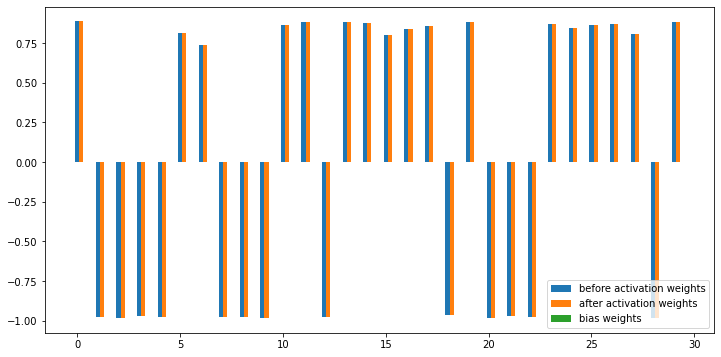

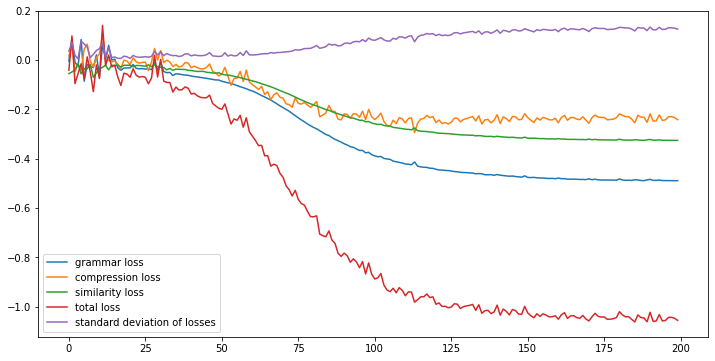

('서산시의회(의장 수여하는 우수의정대상을 이수의 의원은 팔봉면 폰타나 리조트에서 열린 한국지역신문협회 워크샵에서 활발한 의정활동을 펼친 공로를 인정받아 수상했다.',
 5.7462728661968665)

In [68]:
txt = """
서산시의회(의장 임재관) 가충순·이수의 의원이 (사)한국지역신문협회에서 수여하는 우수의정대상을 받았다. 가충순 의원과 이수의 의원은 16일 팔봉면 폰타나 리조트에서 열린 한국지역신문협회 하계 워크샵에서 지역사회 발전을 위해 활발한 의정활동을 펼친 공로를 인정받아 우수의정대상을 수상했다.
"""
sam_wgan4(txt,txt,epochs=200,display= True,retry = False)

# Sentence Corrector (EncoderDecoderModel)

In [77]:
from transformers import EncoderDecoderModel, BertTokenizerFast
import torch

pre_trained_kobert_model_name='kykim/bert-kor-base'

tokenizer = BertTokenizerFast.from_pretrained(pre_trained_kobert_model_name)

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

In [71]:
from transformers import EncoderDecoderModel, BertTokenizerFast

model = EncoderDecoderModel.from_pretrained("/content/drive/MyDrive/GAN_ENDE/sentence_complete_model")

In [80]:
def sentence_correct(text):
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    model.to(device)
    model.eval()
    outputs = model.generate(input_ids, attention_mask=attention_mask).cpu().detach().numpy()[0]
    o=[]
    for token in outputs:
        if token == tokenizer.pad_token_id:
            break
        o.append(token)
    output_str = tokenizer.batch_decode([o], skip_special_tokens=True)[0]
    eos = output_str.find('.')
    output_str = output_str[0:eos+1]
    return output_str

In [81]:
sentence_correct('옛날 귀여운 여자 아기가 태어나 마음씨 소녀가 되었어요.')

'옛날 귀여운 여자 아기가 태어나 마음씨 좋은 소녀가 되었어요.'

In [34]:
full_text = """
옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 지나서 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두명의 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 쓸고, 닦고, 하녀처럼 하루 종일 집안일을 도맡아 했어요.
집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했어요.
그러던 어느날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 무도회 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
그때 어디선가 마법사 할머니가 나타났어요.
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
할머니는 소녀를 무도회에 보내줄테니 호박 한개와 생쥐 두마리, 도마뱀을 가지고 오라 했어요.
마법사 할머니가 이것들을 보면서 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했어요.
신데렐라의 낡은 옷은 구슬 장식이 반짝이는 예쁜 드레스로 바뀌었어요.
할머니는 신데렐라에게 반짝반짝 빛나는 유리구두를 신겨 주었어요.
그리고 밤 열두시가 되면 모든게 처음대로 돌아간다고 알려주었어요.
황금마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼어요. 
그러니까 반드시 밤 열두시가 되기 전에 돌아와야 해요.
신데렐라는 황금마차를 타고 왕궁 무도회장으로 가서 멋진 왕자님을 만났어요.
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고 신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
어느덧 시간이 흘러 열두시가 되었어요. 
벽시계의 열두시를 알리는 종소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데, 유리구두 한짝이 벗겨졌어요.
하지만 구두를 주울 시간이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리구두 한짝을 주웠어요.
왕자님은 유리구두를 가지고 임금님께 가서 말했어요.
이 유리구두의 주인과 결혼하겠어요.
그래서 신하들은 유리구두의 주인을 찾아 온 나라를 돌아다녔어요.
드디어 신데렐라의 집에까지 신하들이 도착했어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리구두는 너무 작았어요.
그때 신데렐라가 조용히 다가와 자기도 한번 신어보게 해달라고 부탁했어요.
신데렐라는 신하에게서 받은 유리구두를 신었어요.
유리구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요.
"""

In [86]:
def summary(text):
    org_sentences = np.array(nltk.sent_tokenize(text.strip()))
    summary_text = []
    for i in range(0,len(org_sentences),2):
        txt = org_sentences[i]
        if i < len(org_sentences)-1:
            txt +=  ' ' + org_sentences[i+1]
        t,score = sam_wgan4(text,txt.strip(),epochs=50)
        print('-'*50)
        print(t,score)
        t = sentence_correct(t)
        print(t)
        summary_text.append(t)

    return ' '.join(summary_text).strip()

In [96]:
org_text = summary(full_text)
print('-'*50)
for txt in np.array(nltk.sent_tokenize(org_text.strip())):
    print(txt)

org_text = summary(org_text)
print('-'*50)
for txt in np.array(nltk.sent_tokenize(org_text.strip())):
    print(txt)


--------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요.
--------------------------------------------------
Train... |||||||||||||||||||||| 100.0%   50/50 epochs, e 0.09162723533612306, grammar loss:-0.0009  similarity loss:-0.0014 length loss:-0.0066
--------------------------------------------------
옛날 어느 집에 여자 아기가 자라서 예쁘고 마음씨 되었어요. 4.473997160644772
옛날 어느 집에 사는 여자 아기가 자라서 예쁘고 마음씨 좋은 사람이 되었다.
--------------------------------------------------
그러던 어느날 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
--------------------------------------------------
Train... |||||||||||||||||||||| 100.0%   50/50 epochs, e 0.09162723533612306, grammar loss:-0.0054  similarity loss:0.0010 length loss:-0.0000
max score: 3.1177924291490053 소녀의 어머니가 병이들어 떠나고 홀로 남은 소녀가
--------------------------------------------------
그러던 어느날 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
--------------------------------------------------
Train... |